### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

## Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [27]:
data['distance_km']

id
id2875421    1.500479
id2377394    1.807119
id3858529    6.392080
id3504673    1.487155
id2181028    1.189925
               ...   
id2376096    1.226296
id1049543    6.056935
id2304944    7.832952
id2714485    1.093786
id1209952    1.135453
Name: distance_km, Length: 1458644, dtype: float64

In [18]:
### Your code is here

popular_category = data['passenger_count'].value_counts().index[0]
data['passenger_count'] = data['passenger_count'].fillna(popular_category)

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [37]:
### Your code is here

cols_to_group = ['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 
                             'month_2', 'month_3', 'month_4', 'month_5', 'month_6']
mean_value = data.groupby(cols_to_group)['distance_km'].transform("mean")
data['distance_km'] = data['distance_km'].fillna(mean_value)

data.head(20).to_csv('output_csv', sep = ';', index= False)

In [40]:
### Убедимся, что пропусков не осталось
mean_value
### Your code is here


id
id2875421    3.466395
id2377394    3.463570
id3858529    3.183494
id3504673    3.468311
id2181028    3.466395
               ...   
id2376096    3.468311
id1049543    3.323767
id2304944    3.468311
id2714485    3.323767
id1209952    3.389926
Name: distance_km, Length: 1458644, dtype: float64

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [82]:
from sklearn.model_selection import train_test_split

X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [55]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()

result = cross_validate(model,X, y, 
                           scoring='neg_mean_squared_error',
                           cv=selector, return_train_score=True) 



### Your code is here
print(round(-np.mean(result['test_score']),3))


In [56]:
round(-np.mean(result['test_score']),3)

0.431

### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

{'whiskers': [<matplotlib.lines.Line2D at 0x21f23dae290>,
 'caps': [<matplotlib.lines.Line2D at 0x21f23dd7450>,
 'boxes': [<matplotlib.lines.Line2D at 0x21f10bfc750>],
 'medians': [<matplotlib.lines.Line2D at 0x21f23de44d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21f23d6ad10>],
 'means': []}

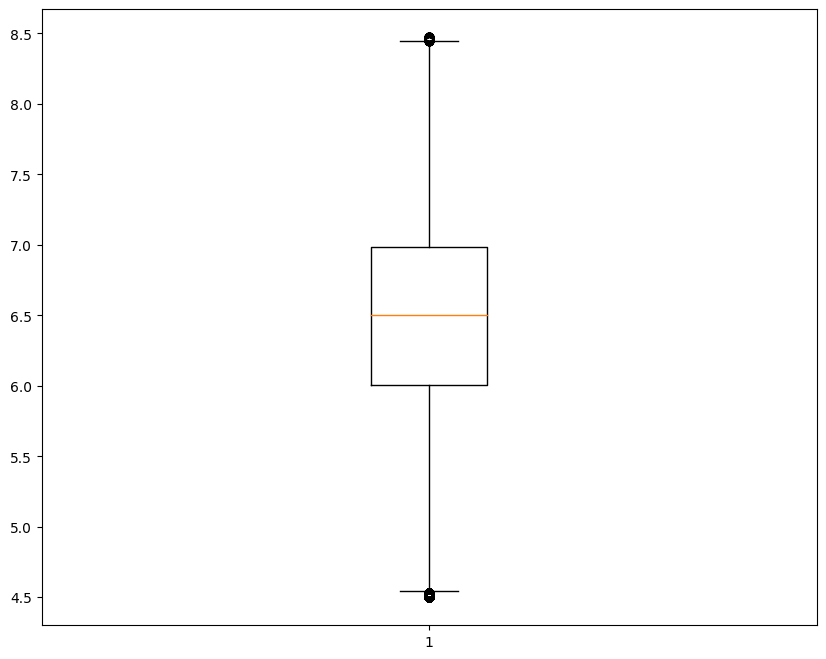

In [88]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(10,8)
plt.boxplot(data['log_trip_duration'].values)
### Your code is here



Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [90]:
### Your code is here

### Расчитаем длину усиков
q_low = data['log_trip_duration'].quantile(0.995)
q_high = data['log_trip_duration'].quantile(0.005)

tentacle_length = q_high - q_low

In [91]:
tentacle_length

-3.5152357320916083

In [79]:
upper_tentacle = q_high + 1.5 * tentacle_length
lower_tanticle = q_low -1.5 * tentacle_length

In [80]:
lower_tanticle

4.4946214021285

In [68]:
upper_tentacle

8.472836343877669

In [92]:
### Уберем все данные, в которых таргет - за пределами верхнего усика
data = data[data['log_trip_duration']<upper_tentacle]
data = data[data['log_trip_duration']>lower_tanticle]

<Axes: >

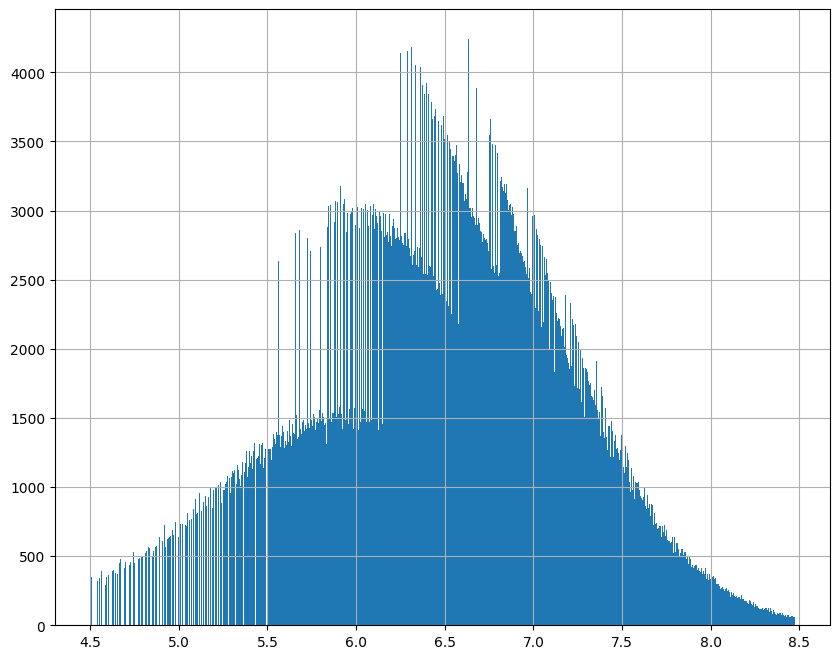

In [93]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(10,8)
data['log_trip_duration'].hist(bins=1000)
### Your code is here



{'whiskers': [<matplotlib.lines.Line2D at 0x21f2e1ed810>,
 'caps': [<matplotlib.lines.Line2D at 0x21f2e1eeb50>,
 'boxes': [<matplotlib.lines.Line2D at 0x21f2e194750>],
 'medians': [<matplotlib.lines.Line2D at 0x21f2e1ef990>],
 'fliers': [<matplotlib.lines.Line2D at 0x21f2e160210>],
 'means': []}

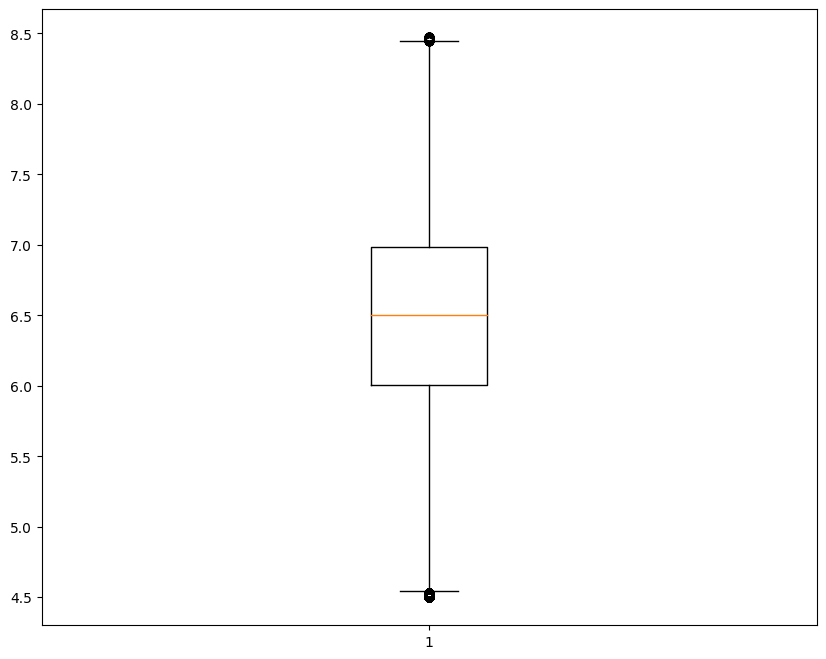

In [95]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_size_inches(10,8)
plt.boxplot(y)
### Your code is here



Снова замерьте качество на кросс-валидации, используя старый selector

In [94]:
### Your code is here

from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

model = LinearRegression()

result = cross_validate(model,X, y, 
                           scoring='neg_mean_squared_error',
                           cv=selector, return_train_score=True) 



### Your code is here
print(round(-np.mean(result['test_score']),3))


0.326
